In [1]:
import sys
sys.path.append('../sgmm')
sys.path.append('../metrics')
sys.path.append('../loaders')
sys.path.append('../Misc')
sys.path.append('../visual')
sys.path.append('../otherModels')
sys.path.append('../LogOdds')

In [2]:
from metricsFunctions import optimalTau,calc_metrics 
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.cluster import KMeans
from classificationBinaryGL import binaryCadreModel

In [3]:
%load_ext autoreload
%autoreload 2

# Caution: Even though the name is newborn, it is pregnancy!!!

In [4]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/SPARCS_Subsets/sparcs25%Preg_DeHos_Outflow_NYC_only.csv") 


newborn = sparcs.sample(frac=1,random_state=1512)

d_newborn_tr,d_newborn_te = train_test_split(newborn, test_size=0.2, random_state = 1512)


In [5]:
# initializing with kmeans
kmeans = KMeans(n_clusters = 9,random_state=0).fit(d_newborn_tr.iloc[:,:-1].values)

Centers = kmeans.cluster_centers_ 

d = np.ones(d_newborn_tr.iloc[:,:-1].shape[1])

inits = {'C':np.transpose(Centers),'d':d}

newborn_best = binaryCadreModel(
    Tmax=1401, record=50,gamma=8.,
    M=9, alpha_d=0.99, alpha_W=0.05, lambda_d=1e-4, lambda_W=0.4,eta=2e-2)
newborn_best.fit(d_newborn_tr, 'Target', None, None, d_newborn_te, progress=True,inits=inits)

W0806 12:36:56.339815 139634158708544 deprecation_wrapper.py:119] From /data/CDPHP/xiao/SGMM/NYC_NEWBORN/classificationBinaryGL.py:125: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0806 12:36:56.385663 139634158708544 deprecation_wrapper.py:119] From /data/CDPHP/xiao/SGMM/NYC_NEWBORN/classificationBinaryGL.py:152: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 12:36:56.539481 139634158708544 deprecation_wrapper.py:119] From /data/CDPHP/xiao/SGMM/NYC_NEWBORN/classificationBinaryGL.py:179: The name tf.log is deprecated. Please use tf.math.log instead.

W0806 12:36:56.578535 139634158708544 deprecation_wrapper.py:119] From /data/CDPHP/xiao/SGMM/NYC_NEWBORN/classificationBinaryGL.py:198: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0806 12:36:56.664426 139634158708544 deprecation.py:323] From /home/shoux/.conda/envs/health3/lib/python

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
50 20.941545 0.5393102525953293 20.940315 0.5430290872617853 0.33450818061828613
100 15.38455 0.7780638258747221 15.384569 0.7778000668672684 18.455816984176636
150 12.782501 0.7795349303732928 12.783211 0.7787362086258777 35.19687294960022
200 11.00688 0.7795349303732928 11.008074 0.7788699431628218 51.75367093086243
250 9.6922455 0.7806215416506461 9.693188 0.7796723503844868 67.41789364814758
300 8.646722 0.7844999080559688 8.647962 0.783015713808091 80.16362428665161
350 7.8638077 0.7892977147728982 7.8653183 0.787897024406553 93.1918842792511
400 7.3178644 0.7911031612029623 7.3195467 0.7898361751922434 107.19862842559814
450 6.901684 0.7930423444056236 6.9033813 0.7923102641257105 121.03843283653259
500 6.659509 0.7939617847172303 6.6611505 0.7931795386158476 136.2225592136383
550 6.456378 0.7948979421254116 6.4581795 0.7941156803744567 149.86677622795105
600 6.360

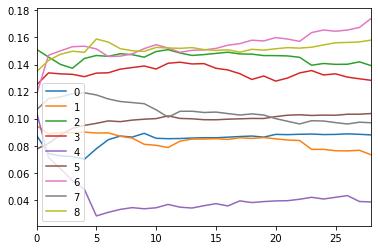

In [6]:
# size of cadre vs iterations

newborn_best.proportions.plot()

In [52]:
newborn_best.scoreMetrics(d_newborn_te)

,loss,accuracy,ROC_AUC,PR_AUC
0,5.978224,0.796523,0.791043,0.61475


In [50]:
## example of how to use precision_metrics()
from precision_metrics import precision_metrics
scores_preg = precision_metrics(d_newborn_tr,d_newborn_te, newborn_best, 'pregnancy')

In [51]:
scores_preg

,dataset,m,size,proportion,accuracy,ROC_AUC,PR_AUC,F1_score
0,pregnancy,0,1305,0.760153,0.760920,0.765477,0.894666,0.879817
1,pregnancy,1,1089,0.269972,0.730946,0.825529,0.625740,0.625000
2,pregnancy,2,2094,0.219675,0.779847,0.750294,0.440448,0.478610
3,pregnancy,3,1942,0.330072,0.673018,0.723456,0.546810,0.574321
4,pregnancy,4,547,0.294333,0.705667,0.749582,0.523789,0.551887
5,pregnancy,5,1540,0.106494,0.893506,0.774800,0.273127,0.368794
6,pregnancy,6,2561,0.113237,0.886763,0.663155,0.179096,0.273214
7,pregnancy,7,1430,0.237063,0.765035,0.651816,0.379064,0.441860
8,pregnancy,8,2447,0.159787,0.840213,0.711307,0.316296,0.390164


In [9]:
# overall F1 score
def overallf1(train,test,model):
    Ftr, __, __, __, __ = model.predictFull(train)
    Fte, __, __, __, __ = model.predictFull(test)
    tau = optimalTau(np.squeeze(Ftr), (train.iloc[:,-1].values))
    y_pred = (np.squeeze(Fte) >= tau)*1
    return f1_score(test.iloc[:,-1].values, y_pred)

In [10]:
# overall f1 score for newborn, circ and preg
f1_preg=overallf1(d_newborn_tr,d_newborn_te,newborn_best)
f1_preg

0.5675996204933587

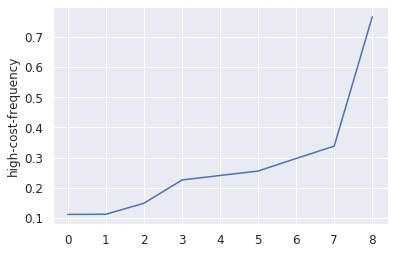

In [37]:
# just change the order of labels so that cost for each cluster goes from low to high
__, __, __, labTrain, __ = newborn_best.predictFull(d_newborn_tr)
__, __, __, labTest, __ = newborn_best.predictFull(d_newborn_te)
Labels = np.append(labTrain,labTest)

target= pd.DataFrame(np.append(d_newborn_tr.iloc[:,-1],d_newborn_te.iloc[:,-1],axis=0),columns=['Target'])
cadre = pd.DataFrame(Labels,columns=['Cadre'])
target['Cadre']= cadre['Cadre']
highcostratio = np.array([])
clustpop = np.array([])
for i in range(9):
    pop = target[target['Cadre']==i]['Target'].shape[0]
    clustpop = np.append(clustpop,pop)
    ratio = np.count_nonzero(target[target['Cadre']==i]['Target'].values)*1.0/pop
    highcostratio= np.append(highcostratio,ratio)
x = np.arange(9)
b=sns.lineplot(x=x,
               y=sorted(highcostratio))
plt.xticks(x,x)
#b.set_xlabel("X Label",fontsize=30)
b.set_ylabel("high-cost-frequency",fontsize=12)
b.tick_params(labelsize=12)

In [38]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2   

In [40]:
#plot highcost ratio among cadres
from ftest_logodds import restest
restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1)).round(2)

array([-1.06, -1.12, -0.75, -0.16, -0.06,  0.03,  0.25,  0.5 ,  2.57])

In [56]:
# Calculate log odds ratios for feature vs. cluster, uncorr
from ftest_logodds import ftest_uncorr
features = list(newborn.iloc[:,:-1])
data = np.append(d_newborn_tr.iloc[:,:-1],d_newborn_te.iloc[:,:-1],axis=0)
np_feat = np.asarray(features)
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

In [57]:
# reduce feature length
new_feat = [s.replace('CCS.DX_' , '') for s in features]
new_feat = [s.replace('CCS.PROC_' , '') for s in new_feat]
new_feat = [s.replace(' not mental disorders or infectious disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually transmitted disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]
new_feat = [s.replace('Other','Ot')for s in new_feat]
new_feat = [s.replace('OTHER','Ot')for s in new_feat]

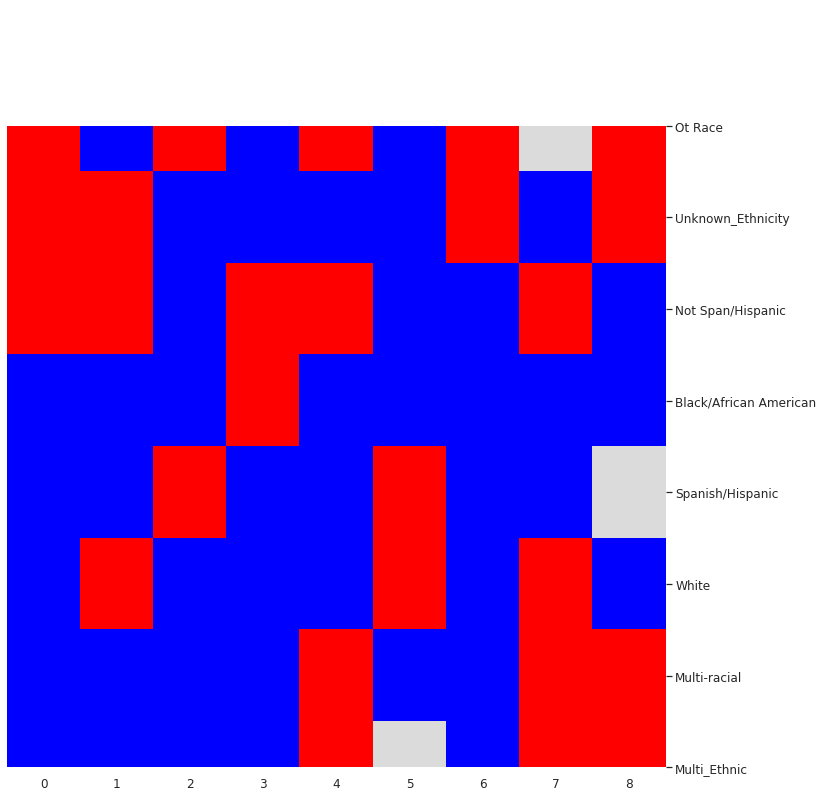

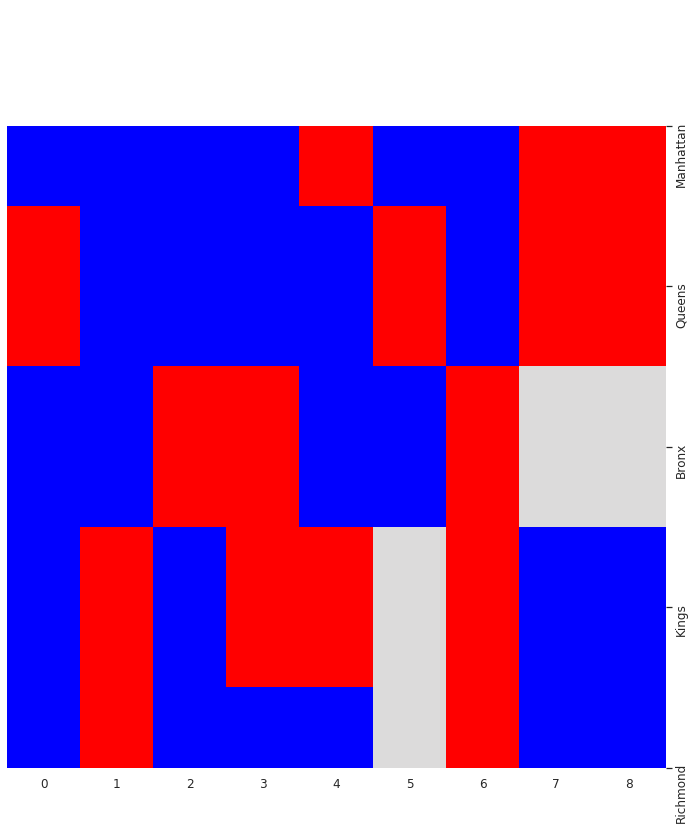

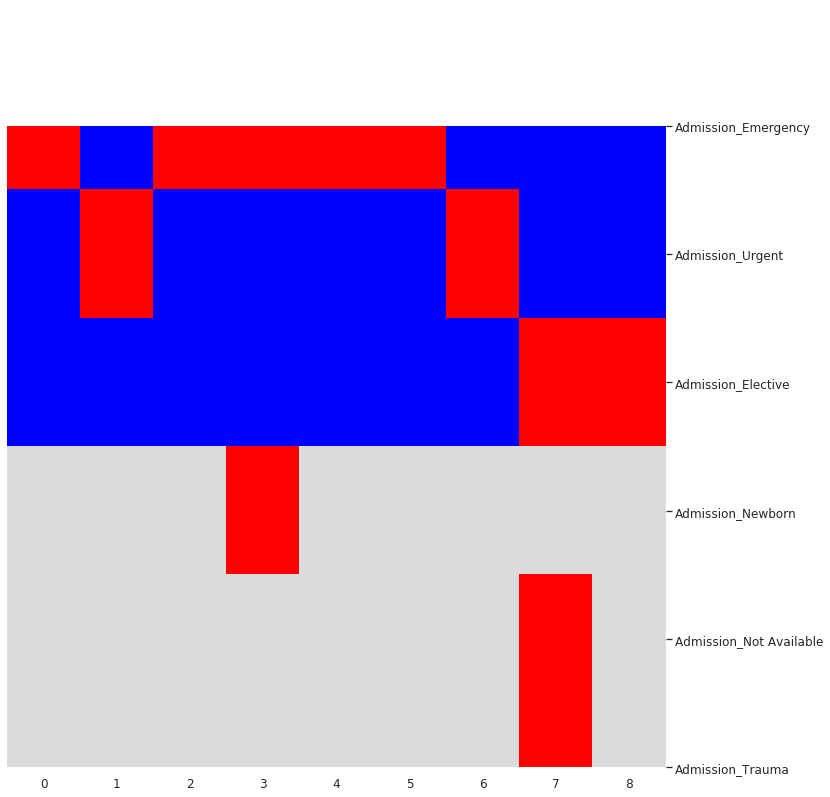

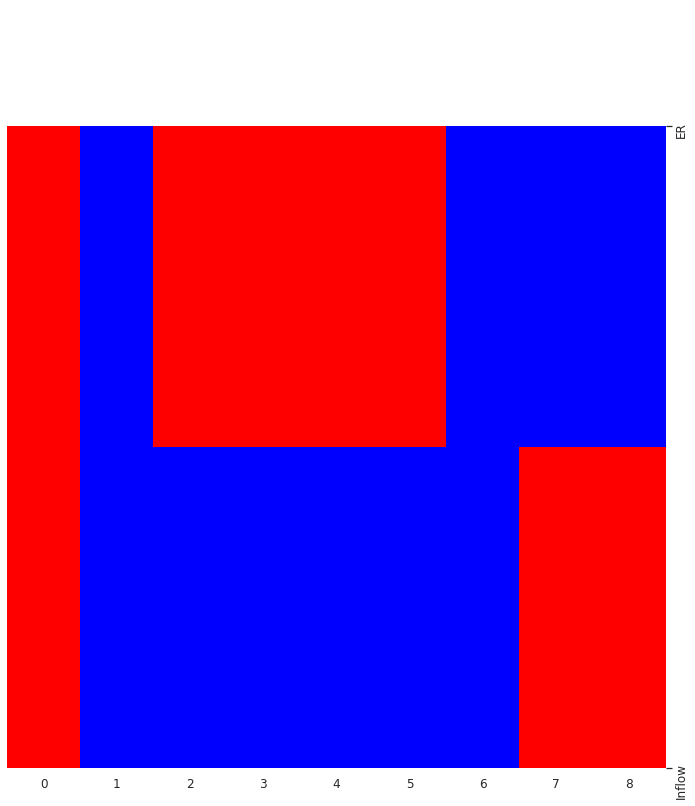

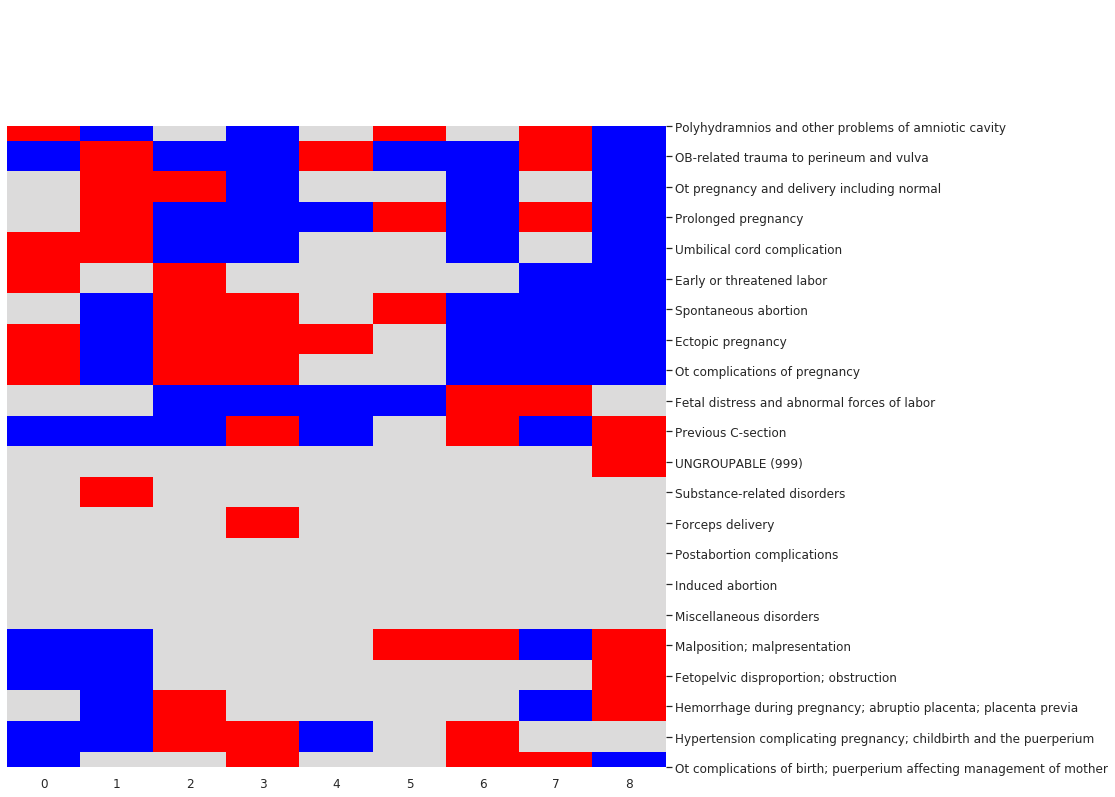

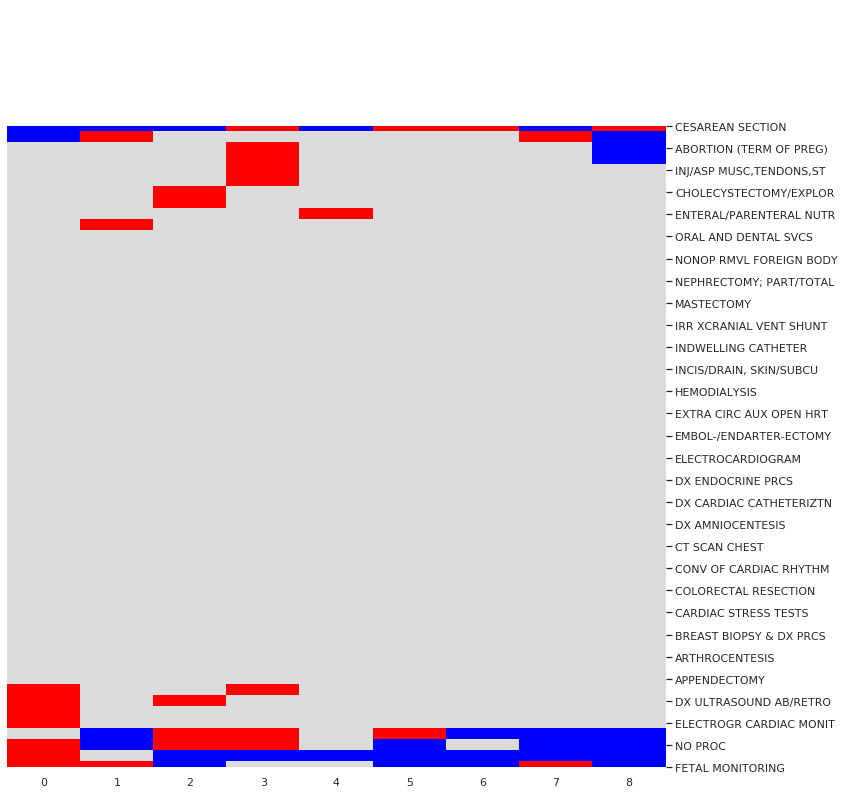

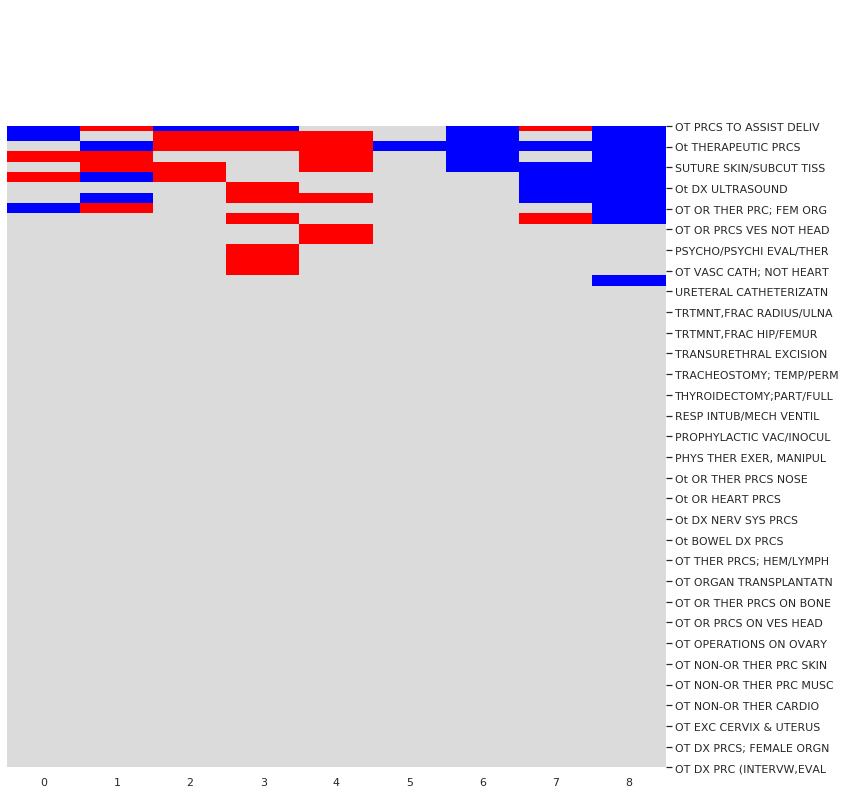

In [132]:
# clustermaps of segments of features.
# Red indicates a given feature has significant positive log ordds ratio to a given cluster, 
# light purple no significance, blue significant negative.
from clustmap import plotclustmap

sns.set(font_scale=1.1)
# racial features
plotclustmap(feat_table[:,7:15].T,None,np.array(new_feat)[7:15],None,None)

# county features
plotclustmap(feat_table[:,2:7].T,None,np.array(new_feat)[2:7],None,None)
plt.yticks(np.arange(len(np.array(new_feat)[2:7]))+1, np.array(new_feat)[2:7], rotation=0)

# # # admission features
plotclustmap(feat_table[:,15:21].T,None,np.array(new_feat)[15:21],None,None)
# ER, Low BW, Inflow
plotclustmap(feat_table[:,0:2].T,None,np.array(new_feat)[0:2],None,None)

# # #disease features
plotclustmap(feat_table[:,23:45].T,None,np.array(new_feat)[23:45],None,None)
# # # procedure features
sns.set(font_scale=1.0)
plotclustmap(feat_table[:,45:105].T,None,np.array(new_feat)[45:105],None,None)
plotclustmap(feat_table[:,105:].T,None,np.array(new_feat)[105:],None,None)

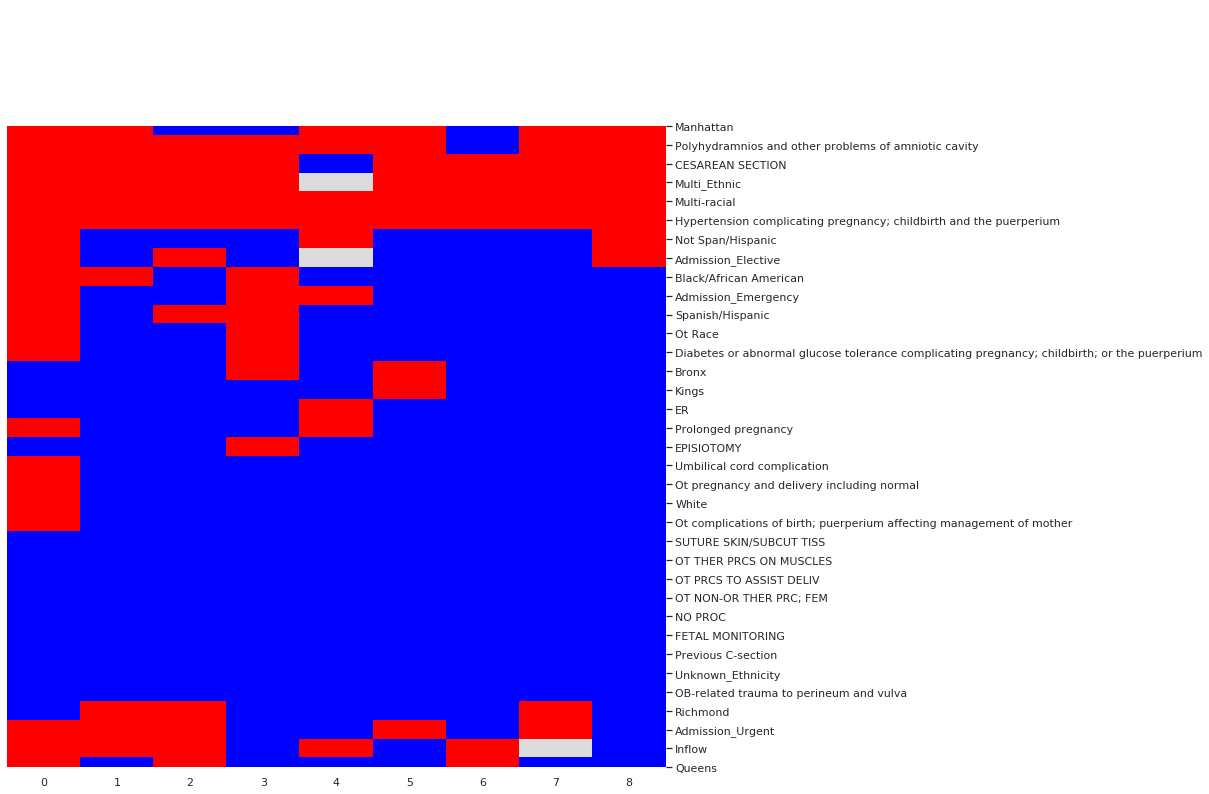

In [129]:
# create a binary version of the weights: red, weight>0, blue , weight <0
bin_weights = (newborn_best.W[abs(newborn_best.W.T).sum()>1e-1]>0)*1 + (newborn_best.W[abs(newborn_best.W.T).sum()>1e-1]<0)*(-1) 
plotclustmap(bin_weights.values,None,np.array(new_feat)[abs(newborn_best.W.T).sum()>1e-1],None,None)